In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Plot of parameter F

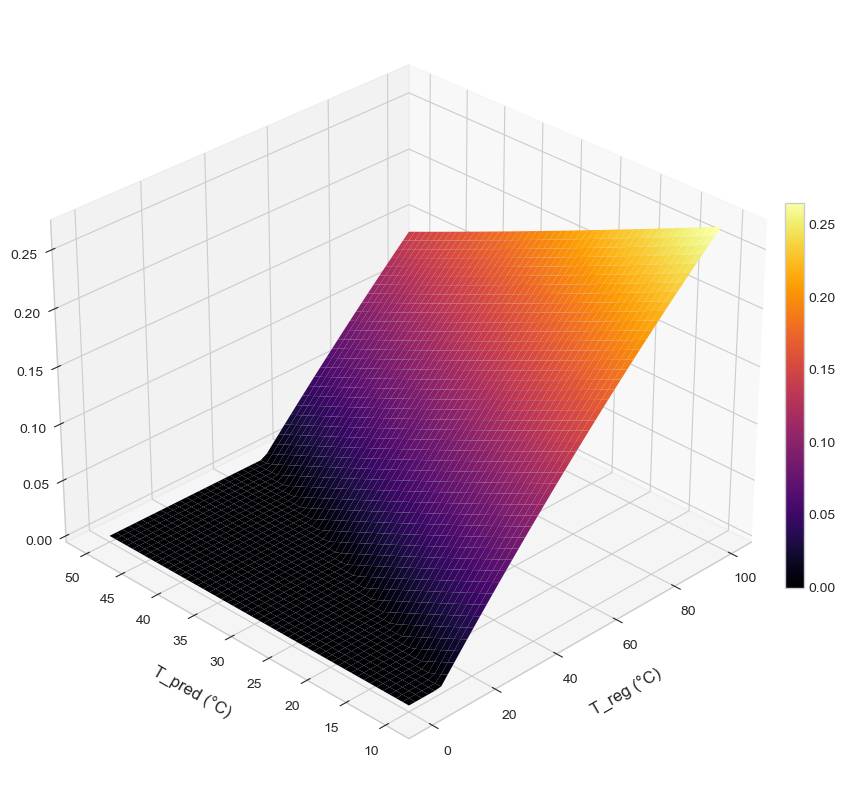

In [2]:
# --- Define the Parameters ---
k = 2

# Range of t and tp (in Celsius)
# It is more readable to define the ranges in °C first
temp_c_values = np.linspace(0, 100, 50) # Reduced to 50 points for a cleaner mesh
pred_c_values = np.linspace(10, 50, 50)

# Convert to Kelvin for the calculation
t_values = temp_c_values + 273.15
tp_values = pred_c_values + 273.15

# Create meshgrid of values
T, TP = np.meshgrid(t_values, tp_values)

# Calculate f(t, tp)
F = np.maximum(0, (T**k - TP**k) / (T**k + TP**k))

# --- Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(12, 8)) # Slightly larger for the color bar
ax = fig.add_subplot(111, projection='3d')

# Use the values in Celsius for the axes
T_C, TP_C = np.meshgrid(temp_c_values, pred_c_values)

# Draw the surface
# We save the surface in a variable 'surf' to be able to add the color bar
surf = ax.plot_surface(T_C, TP_C, F, cmap='inferno', edgecolor='none')

# Axis Labels (including Z)
ax.set_xlabel('T_reg (°C)', fontsize=12, labelpad=10)
ax.set_ylabel('T_pred (°C)', fontsize=12, labelpad=10)
# ax.set_zlabel('Function Value (F)', fontsize=12, labelpad=10) # Z label added!

# Color Bar
# 'shrink' and 'aspect' control the size of the bar
fig.colorbar(surf, shrink=0.5, aspect=20, pad=0.001)

# View Angle
# Adjust 'elev' (elevation) and 'azim' (azimuth) for a better perspective
ax.view_init(elev=30, azim=-135)

# Z-axis Limits (The function F is bounded between 0 and 1)
# ax.set_zlim(0, 1)

# Adjust layout so labels do not overlap
plt.tight_layout()

# plt.savefig('/Users/alzorrcarri/Documents/resisto_synth/ar_lag/results/superficie_funcion.pdf', dpi=300)

# Show
plt.show()

## Study of the optimal order and prediction window

In [ ]:
def calculate_aic_linear(y_true, y_pred, k):
    """
    Calculates the AIC (Akaike Information Criterion) for a linear regression (or AR) model.
    
    Parameters:
    y_true (array): True (observed) values.
    y_pred (array): Values predicted by the model.
    k (int): Number of model parameters (p lags + 1 intercept).
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    # Remove NaN values
    mask = ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    # n is the number of points used for the calculation
    n = len(y_true) 
    
    residuals = y_true - y_pred
    rss = np.sum(residuals**2) # Residual Sum of Squares
    
    # Handle the case of RSS = 0 (perfect fit)
    if rss == 0:
        # Cannot take log(0), but this implies infinite likelihood.
        # In practice, -infinity is returned
        return -np.inf 
    
    # Formula for AIC under the assumption of Normally distributed errors (up to a constant term)
    aic = n * np.log(rss / n) + 2 * k
    
    return aic

Load the different result dataframes, calculate the AIC for each ROI and save it in a dataframe indicating the AR model order, the size of the prediction window in minutes.

In [ ]:
# Function that reads the files from a directory in alphabetical order and returns a DataFrame with the combined data
def read_and_combine_files(directory_path):
    all_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.csv')]
    all_files.sort()  # Sort the files alphabetically
    df_list = [pd.read_csv(file, na_filter='', encoding='latin-1') for file in all_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    # Remove unnamed columns
    combined_df = combined_df.loc[:, ~combined_df.columns.str.contains('^Unnamed')]
    return combined_df

### Prediction window: 30 min

In [5]:
temperatures_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_30min/temperatures')
pred_lag10_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_30min/predicted/order_10')
pred_lag25_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_30min/predicted/order_25')
pred_lag50_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_30min/predicted/order_50')
pred_lag100_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_30min/predicted/order_100')
pred_lag200_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_30min/predicted/order_200')
pred_lag288_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_30min/predicted/order_288')
pred_lag400_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_30min/predicted/order_400')

In [6]:
aic_lag10 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag10_df[column], k=10+1)
        aic_lag10.append(aic_value)

aic_lag25 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag25_df[column], k=25+1)
        aic_lag25.append(aic_value)

aic_lag50 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag50_df[column], k=50+1)
        aic_lag50.append(aic_value)

aic_lag100 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag100_df[column], k=100+1)
        aic_lag100.append(aic_value)

aic_lag200 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag200_df[column], k=200+1)
        aic_lag200.append(aic_value)

aic_lag288 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag288_df[column], k=288+1)
        aic_lag288.append(aic_value)
    
aic_lag400 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag400_df[column], k=400+1)
        aic_lag400.append(aic_value)

In [ ]:
aic_pw30_df = pd.DataFrame({
    'order_10': aic_lag10,
    'order_25': aic_lag25,
    'order_50': aic_lag50,
    'order_100': aic_lag100,
    'order_200': aic_lag200,
    'order_288': aic_lag288,
    'order_400': aic_lag400
})
aic_pw30_df.index = [col for col in temperatures_df.columns if col != 'timestamp']
# aic_pw30_df.to_csv('/Users/alzorrcarri/Documents/resisto_synth/ar_lag/results/aic_pw30_df.csv')

### Prediction window: 1 h

In [8]:
temperatures_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_60min/temperatures')
pred_lag10_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_60min/predicted/order_10')
pred_lag25_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_60min/predicted/order_25')
pred_lag50_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_60min/predicted/order_50')
pred_lag100_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_60min/predicted/order_100')
pred_lag200_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_60min/predicted/order_200')
pred_lag288_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_60min/predicted/order_288')
pred_lag400_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_60min/predicted/order_400')

In [9]:
aic_lag10 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag10_df[column], k=10+1)
        aic_lag10.append(aic_value)

aic_lag25 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag25_df[column], k=25+1)
        aic_lag25.append(aic_value)

aic_lag50 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag50_df[column], k=50+1)
        aic_lag50.append(aic_value)

aic_lag100 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag100_df[column], k=100+1)
        aic_lag100.append(aic_value)

aic_lag200 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag200_df[column], k=200+1)
        aic_lag200.append(aic_value)

aic_lag288 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag288_df[column], k=288+1)
        aic_lag288.append(aic_value)
    
aic_lag400 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag400_df[column], k=400+1)
        aic_lag400.append(aic_value)

In [10]:
aic_pw60_df = pd.DataFrame({
    'order_10': aic_lag10,
    'order_25': aic_lag25,
    'order_50': aic_lag50,
    'order_100': aic_lag100,
    'order_200': aic_lag200,
    'order_288': aic_lag288,
    'order_400': aic_lag400
})
aic_pw60_df.index = [col for col in temperatures_df.columns if col != 'timestamp']
aic_pw60_df.to_csv('/Users/alzorrcarri/Documents/resisto_synth/ar_lag/results/aic_pw60_df.csv')

### Prediction window: 3h

In [11]:
temperatures_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_180min/temperatures')
pred_lag10_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_180min/predicted/order_10')
pred_lag25_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_180min/predicted/order_25')
pred_lag50_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_180min/predicted/order_50')
pred_lag100_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_180min/predicted/order_100')
pred_lag200_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_180min/predicted/order_200')
pred_lag288_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_180min/predicted/order_288')
pred_lag400_df = read_and_combine_files('/Volumes/Crucial X9/resisto_synth/ar_lag/output/timeseries/SYN_A/pw_180min/predicted/order_400')

In [12]:
aic_lag10 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag10_df[column], k=10+1)
        aic_lag10.append(aic_value)

aic_lag25 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag25_df[column], k=25+1)
        aic_lag25.append(aic_value)

aic_lag50 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag50_df[column], k=50+1)
        aic_lag50.append(aic_value)

aic_lag100 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag100_df[column], k=100+1)
        aic_lag100.append(aic_value)

aic_lag200 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag200_df[column], k=200+1)
        aic_lag200.append(aic_value)

aic_lag288 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag288_df[column], k=288+1)
        aic_lag288.append(aic_value)
    
aic_lag400 = []
for column in temperatures_df:
    if column != 'timestamp':
        aic_value = calculate_aic_linear(temperatures_df[column], pred_lag400_df[column], k=400+1)
        aic_lag400.append(aic_value)

In [13]:
aic_pw180_df = pd.DataFrame({
    'order_10': aic_lag10,
    'order_25': aic_lag25,
    'order_50': aic_lag50,
    'order_100': aic_lag100,
    'order_200': aic_lag200,
    'order_288': aic_lag288,
    'order_400': aic_lag400
})
aic_pw180_df.index = [col for col in temperatures_df.columns if col != 'timestamp']
aic_pw180_df.to_csv('/Users/alzorrcarri/Documents/resisto_synth/ar_lag/results/aic_pw180_df.csv')

### Graphical representation

We do a 3D plot where the X axis is the model order, the Y axis is the size of the prediction window, and the Z axis is the AIC value. Each value will have a color according to the corresponding ROI.

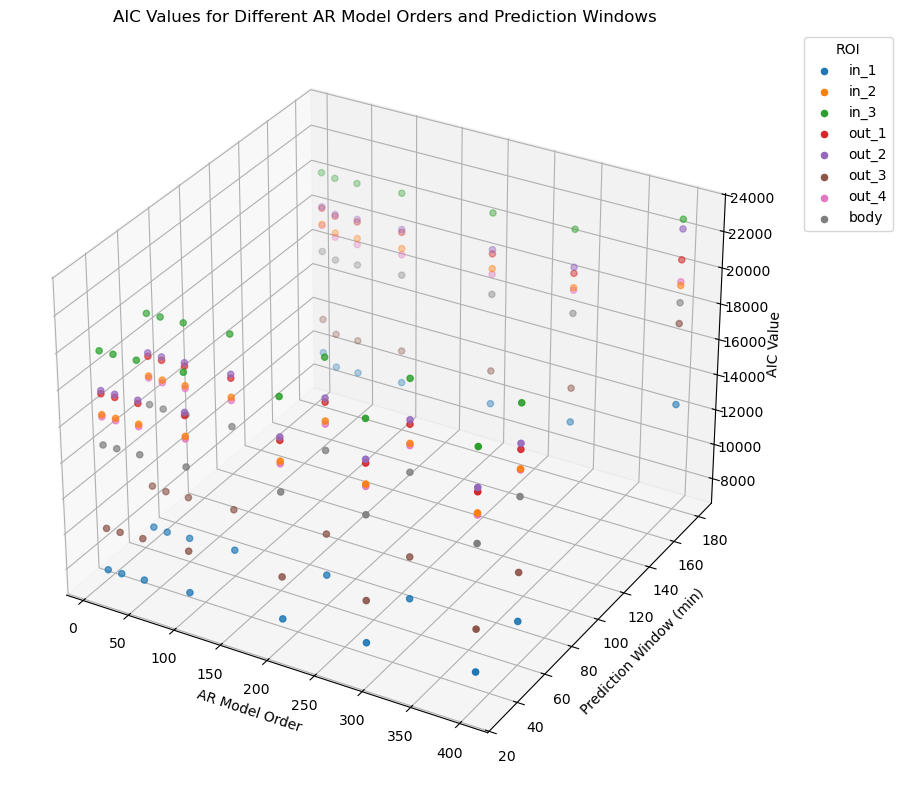

In [ ]:
# Define parameters
orders = [10, 25, 50, 100, 200, 288, 400]
prediction_windows = [30, 60, 180]  # in minutes
aic_values = {
    30: aic_pw30_df,
    60: aic_pw60_df,
    180: aic_pw180_df
}

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for roi in aic_pw30_df.index:
    if roi == 'background':
        continue  # Omit the 'background' ROI for better clarity

    xs = orders
    ys = prediction_windows
    
    # Collect Z values (AIC) for the current ROI across all prediction windows
    zs = [aic_values[wp].loc[roi].values for wp in prediction_windows]

    # Flatten zs into a single list
    zs_flat = [item for sublist in zs for item in sublist]

    # Repeat xs and ys for each prediction window to match the flattened zs
    xs_repeated = xs * len(prediction_windows)
    
    ys_repeated = []
    for wp in prediction_windows:
        ys_repeated.extend([wp] * len(orders))
        
    ax.scatter(xs_repeated, ys_repeated, zs_flat, label=roi)

# Labels
ax.set_xlabel('AR Model Order')
ax.set_ylabel('Prediction Window (min)')
ax.set_zlabel('AIC Value')
ax.set_title('AIC Values for Different AR Model Orders and Prediction Windows')

# Legend
ax.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('/Users/alzorrcarri/Documents/resisto_synth/ar_lag/results/aic_3d_plot.pdf', dpi=300)
plt.show()

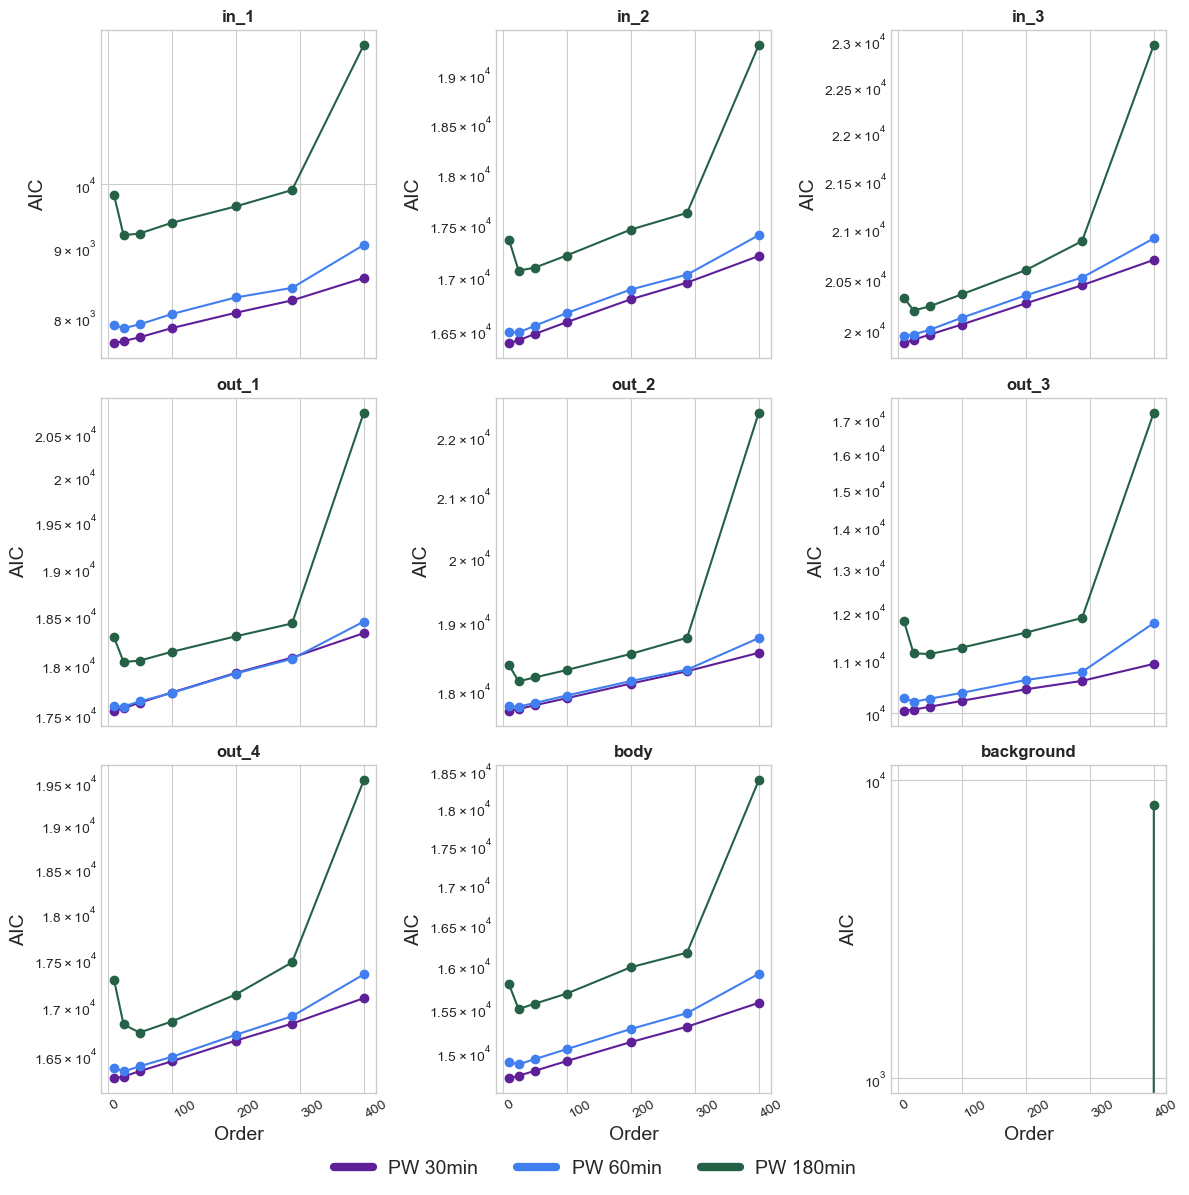

In [ ]:
# Plot showing the evolution of AIC as a function of model order for each prediction window and each ROI
# Create subplots for each ROI (in_1, in_2, in_3, out_1, out_2, out_3, out_4, body, and background)
import matplotlib.pyplot as plt
colors = ['#DCF0EC','#9AD6D0','#5E1F99','#B69DB7','#417EF0','#C8EFBE','#256146','#B3CDEA','#8A73F0','#EA9C2F']
plt.style.use('seaborn-v0_8-whitegrid')

orders = [10, 25, 50, 100, 200, 288, 400]

fig = plt.figure(figsize=(12, 12))
for i, index in enumerate(aic_pw30_df.index):
    ax = fig.add_subplot(3, 3, i+1)
    ax.plot(orders, aic_pw30_df.loc[index], label=f'PW 30min {index}', marker='o', color=colors[2])
    ax.plot(orders, aic_pw60_df.loc[index], label=f'PW 60min {index}', marker='o', color=colors[4])
    ax.plot(orders, aic_pw180_df.loc[index], label=f'PW 180min {index}', marker='o', color=colors[6])
    ax.set_yscale('log')
    ax.set_title(f'{index}', fontweight='bold')
    ax.set_xlabel('Order', fontsize=14)
    ax.set_ylabel('AIC', fontsize=14)

# Global Legend
handles = [
    plt.Line2D([], [], color=colors[2], lw=6, label='PW 30min'),
    plt.Line2D([], [], color=colors[4], lw=6, label='PW 60min'),
    plt.Line2D([], [], color=colors[6], lw=6, label='PW 180min')
]

fig.legend(handles=handles, loc='lower center', ncol=4, fontsize=14)
fig.autofmt_xdate(rotation=30, ha='left')

fig.tight_layout(rect=[0, 0.03, 1, 1]) 

plt.savefig('/Users/alzorrcarri/Documents/resisto_synth/ar_lag/results/aic_evolution_all_rois_logscale.pdf', dpi=300)
plt.show()
